In [5]:
import pandas as pd
from collections import Counter
import re
import numpy as np
from sklearn.utils import shuffle
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
from sklearn.metrics import f1_score, accuracy_score 
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [35]:
import sys
import csv

In [75]:
# Reading The Guardian dataset
df_guard = pd.read_csv("C:/Users/Vidyajay/Desktop/SourceCode/Cleaning Data/guardian cleaned.csv")

In [76]:
# Adding column of fakeness to the dataset and showing the column names
df_guard["fakeness"] = 0
df_guard.columns

Index(['Unnamed: 0', 'apiUrl', 'fields', 'id', 'isHosted', 'pillarId',
       'pillarName', 'sectionId', 'sectionName', 'type', 'webPublicationDate',
       'webTitle', 'webUrl', 'bodyText', 'headline', 'fakeness'],
      dtype='object')

In [77]:
df_kaggle = pd.read_csv("C:/Users/Vidyajay/Desktop/SourceCode/Cleaning Data/kaggle cleaned.csv")

In [40]:
# showing the column names
df_kaggle.columns

Index(['Unnamed: 0', 'author', 'title', 'text', 'language', 'site_url', 'type',
       'published', 'uuid', 'fakeness'],
      dtype='object')

In [41]:
df_nyt=pd.read_csv("C:/Users/Vidyajay/Desktop/SourceCode/Cleaning Data/nyt cleaned.csv")

In [42]:
df_nyt.columns

Index(['Unnamed: 0', 'index', '_id', 'headline', 'pub_date', 'body', 'head1'], dtype='object')

In [43]:
df_nyt["fakeness"]=0
df_nyt.drop(['Unnamed: 0','index','head1'] , inplace=True , axis=1)
df_nyt.columns

Index(['_id', 'headline', 'pub_date', 'body', 'fakeness'], dtype='object')

In [44]:
df_guard.drop(['Unnamed: 0', 'apiUrl', 'fields', 
        'isHosted', 'sectionId', 'sectionName', 'type',
         'webTitle', 'webUrl','pillarId','pillarName'],inplace=True,axis=1)

In [45]:
df_guard.columns

Index(['id', 'webPublicationDate', 'bodyText', 'headline', 'fakeness'], dtype='object')

In [46]:
# Dropping unnecesary columns
df_kaggle.drop([ 'Unnamed: 0',  'language', 'site_url' ,'type','author'],inplace=True,axis=1)
df_kaggle.columns


Index(['title', 'text', 'published', 'uuid', 'fakeness'], dtype='object')

In [47]:
# Changing the name of the column for concating later
df_guard = df_guard.rename(columns={'bodyText' : 'body','webPublicationDate':'published'})
df_kaggle = df_kaggle.rename(columns={'text':'body','title':'headline','uuid':'id'})
df_nyt=df_nyt.rename(columns={'_id':'id','pub_date':'published'})
df_kaggle.columns,df_guard.columns,df_nyt.columns

(Index(['headline', 'body', 'published', 'id', 'fakeness'], dtype='object'),
 Index(['id', 'published', 'body', 'headline', 'fakeness'], dtype='object'),
 Index(['id', 'headline', 'published', 'body', 'fakeness'], dtype='object'))

In [48]:
print("The number of genuine articles in kaggle dataset are "+str(df_kaggle.shape[0]))

The number of genuine articles in kaggle dataset are 11677


In [49]:
df_kaggle.head()

,headline,body,published,id,fakeness
0,Muslims BUSTED: They Stole Millions In Govâ€™t...,Print They should pay all the back all the mon...,2016-10-26T21:41:00.000+03:00,6a175f46bcd24d39b3e962ad0f29936721db70db,1
1,Re: Why Did Attorney General Loretta Lynch Ple...,Why Did Attorney General Loretta Lynch Plead T...,2016-10-29T08:47:11.259+03:00,2bdc29d12605ef9cf3f09f9875040a7113be5d5b,1
2,BREAKING: Weiner Cooperating With FBI On Hilla...,Red State : \nFox News Sunday reported this mo...,2016-10-31T01:41:49.479+02:00,c70e149fdd53de5e61c29281100b9de0ed268bc3,1
3,PIN DROP SPEECH BY FATHER OF DAUGHTER Kidnappe...,Email Kayla Mueller was a prisoner and torture...,2016-11-01T05:22:00.000+02:00,7cf7c15731ac2a116dd7f629bd57ea468ed70284,1
4,FANTASTIC! TRUMP'S 7 POINT PLAN To Reform Heal...,Email HEALTHCARE REFORM TO MAKE AMERICA GREAT ...,2016-11-01T21:56:00.000+02:00,0206b54719c7e241ffe0ad4315b808290dbe6c0f,1


In [50]:
print("The number of articles in Gaurdian dataset are "+str(df_guard.shape[0]))

The number of articles in Gaurdian dataset are 13071


In [51]:
# Overview for data
df_guard.head()

,id,published,body,headline,fakeness
0,world/2018/jan/01/ahed-tamimi-palestinian-girl...,2018-01-01T18:14:19Z,A 16-year-old Palestinian girl who was arreste...,Palestinian girl filmed slapping Israeli soldi...,0
1,world/2018/jan/01/dubai-frame-uaes-latest-surr...,2018-01-01T17:56:01Z,"Home to the tallest skyscraper, the largest sh...",Dubai Frame: UAE's latest surreal landmark fra...,0
2,world/2018/jan/01/arseny-roginsky-obituary,2018-01-01T17:51:24Z,"The Russian historian Arseny Roginsky, who has...",Arseny Roginsky obituary,0
3,world/2018/jan/01/times-up-hollywood-women-lau...,2018-01-01T17:43:38Z,"Three hundred female Hollywood actors, agents,...",Time's Up: Hollywood women launch campaign to ...,0
4,politics/2018/jan/01/nick-boles-third-type-of-...,2018-01-01T17:28:08Z,â€œThoughtfulâ€� Tory MP Nick Boles (Tories sh...,Nick Bolesâ€™ third type of work is an advance...,0


In [52]:
df_nyt.head()

,id,headline,published,body,fakeness
0,5b995d47068401528a2daa07,"Are You Teaching the Midterms?""",2018-09-12T18:39:00+0000,A primary season that has already been full of...,0
1,5b995d8f068401528a2daa08,"You Need to Know to Vote in New York’s Primary """,2018-09-12T18:40:12+0000,"On Thursday — yes, Thursday — voters across Ne...",0
2,5b995e89068401528a2daa0a,Best Photos From New York Fashion Week,2018-09-12T18:44:21+0000,The sixth day of New York Fashion Week was hos...,0
3,5b996210068401528a2daa10,Blue,2018-09-12T18:59:25+0000,"Out of the blackness of the deep, deep ocean c...",0
4,5b99668d068401528a2daa19,"Owens to Guest Star on ‘NCIS: New Orleans’""",2018-09-12T19:18:35+0000,Geoffrey Owens is on the comeback trail. The f...,0


In [53]:
# Concat the datasents
df = df_kaggle.append(df_guard, ignore_index=True)
df=df.append(df_nyt,ignore_index=True)

C:\Users\Nandini\Anaconda3\lib\site-packages\pandas\core\frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


In [54]:
#Dropping the Nan values and info
df.dropna(inplace=True)
print(df.shape)
df.info()

(27610, 5)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 27610 entries, 0 to 27680
Data columns (total 5 columns):
body         27610 non-null object
fakeness     27610 non-null int64
headline     27610 non-null object
id           27610 non-null object
published    27610 non-null object
dtypes: int64(1), object(4)
memory usage: 1.3+ MB


In [55]:
df.head()

,body,fakeness,headline,id,published
0,Print They should pay all the back all the mon...,1,Muslims BUSTED: They Stole Millions In Govâ€™t...,6a175f46bcd24d39b3e962ad0f29936721db70db,2016-10-26T21:41:00.000+03:00
1,Why Did Attorney General Loretta Lynch Plead T...,1,Re: Why Did Attorney General Loretta Lynch Ple...,2bdc29d12605ef9cf3f09f9875040a7113be5d5b,2016-10-29T08:47:11.259+03:00
2,Red State : \nFox News Sunday reported this mo...,1,BREAKING: Weiner Cooperating With FBI On Hilla...,c70e149fdd53de5e61c29281100b9de0ed268bc3,2016-10-31T01:41:49.479+02:00
3,Email Kayla Mueller was a prisoner and torture...,1,PIN DROP SPEECH BY FATHER OF DAUGHTER Kidnappe...,7cf7c15731ac2a116dd7f629bd57ea468ed70284,2016-11-01T05:22:00.000+02:00
4,Email HEALTHCARE REFORM TO MAKE AMERICA GREAT ...,1,FANTASTIC! TRUMP'S 7 POINT PLAN To Reform Heal...,0206b54719c7e241ffe0ad4315b808290dbe6c0f,2016-11-01T21:56:00.000+02:00


In [1]:
df.to_csv("C:/Users/Vidyajay/Desktop/SourceCode/Cleaning Data/final.csv")
df=pd.read_csv("C:Users/Vidyajay/Desktop/SourceCode/Cleaning Data/final.csv")

NameError: name 'df' is not defined

In [6]:
df=pd.read_csv("C:/Users/Vidyajay/Desktop/SourceCode/Cleaning Data/final.csv")

In [98]:
df.shape

(27610, 7)

In [99]:
#modeling

In [7]:
tdf = TfidfVectorizer(stop_words='english',ngram_range=(1,2),max_df=0.85, min_df=0.01 )
X_body=tdf.fit_transform(df.body)
X_headline=tdf.fit_transform(df.headline)
Y=df.fakeness

In [8]:
from sklearn.cross_validation import train_test_split
X_headline_train, X_headline_test, y_headline_train, y_headline_test = train_test_split(X_headline,Y, test_size = 0.25, random_state=420)
X_body_train, X_body_test, y_body_train, y_body_test = train_test_split(X_body,Y, test_size = 0.25, random_state=420)

C:\Users\Nandini\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
#Random Forest
#Using headlines from the dataset
from sklearn.ensemble import RandomForestClassifier

C:\Users\Vidyajay\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [10]:
rcf_headline = RandomForestClassifier(n_estimators=100,n_jobs=3)

In [11]:
rcf_headline.fit(X_headline_train, y_headline_train)
y_rc_headline_pred = rcf_headline.predict(X_headline_test)

In [12]:
# print metrics
print ("Random Forest F1 and Accuracy Scores : \n")
print ( "F1 score {:.4}%".format( f1_score(y_headline_test, y_rc_headline_pred, average='macro')*100 ) )
print ( "Accuracy score {:.4}%".format(accuracy_score(y_headline_test, y_rc_headline_pred)*100) )

Random Forest F1 and Accuracy Scores : 

F1 score 64.58%
Accuracy score 69.52%


In [2]:
from sklearn.metrics import confusion_matrix
y_true = y_headline_test
y_pred = rcf_headline.predict(X_headline_test)
import scikitplot.plotters as skplt
def plot_cmat(y_test, y_pred):
    skplt.plot_confusion_matrix(y_test,y_pred)
    plt.show()
    
plot_cmat(y_true, y_pred)
print("confusion matrix of random forest of headlines")


NameError: name 'y_headline_test' is not defined

In [163]:
#Random Forest
#Using body from the dataset


In [15]:
rcf_body = RandomForestClassifier(n_estimators=100,n_jobs=3)

In [16]:
rcf_body.fit(X_body_train, y_body_train)
y_rc_body_pred = rcf_body.predict(X_body_test)

In [17]:
# print metrics
print ("Random Forest F1 and Accuracy Scores : \n")
print ( "F1 score {:.4}%".format( f1_score(y_body_test, y_rc_body_pred, average='macro')*100 ) )
print ( "Accuracy score {:.4}%".format(accuracy_score(y_body_test, y_rc_body_pred)*100) )

Random Forest F1 and Accuracy Scores : 

F1 score 93.9%
Accuracy score 94.09%


In [18]:
y_body_test.shape

(6903,)

C:\Users\Nandini\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function plot_confusion_matrix is deprecated; This will be removed in v0.4.0. Please use scikitplot.metrics.plot_confusion_matrix instead.
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\Nandini\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


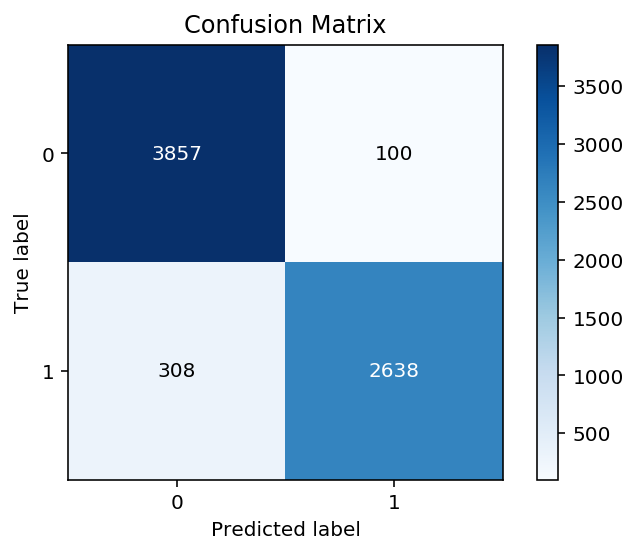

confusion matrix of random forest


In [19]:
import scikitplot.plotters as skplt
def plot_cmat(y_test, y_pred):
    skplt.plot_confusion_matrix(y_test,y_pred)
    plt.show()
    
plot_cmat(y_body_test, y_rc_body_pred)
print("confusion matrix of random forest")